In [7]:
import numpy as np
import torch
from sudoku import Sudoku
from matplotlib import pyplot as plt
import deepsudoku as ds
from deepsudoku.utils import data_utils, sudoku_utils

In [8]:
model = ds.model.SimpleNet()

In [42]:
model.load_state_dict(torch.load("documentation/2.pth")["model_state_dict"])

<All keys matched successfully>

In [17]:
train_sudokus, val_sudokus, test_sudokus = data_utils.load_data()

In [15]:
loss_fn = torch.nn.CrossEntropyLoss()

In [18]:
def natural_distribution():
    possible_numbers_of_moves_to_make = list(range(0,64))
    with open("data/natural_distribution.np", 'rb') as f:
        probabilities = np.load(f)
    probabilities = probabilities/sum(probabilities)
    return possible_numbers_of_moves_to_make, probabilities

train_sudokus = data_utils.make_moves(train_sudokus, natural_distribution)
val_sudokus = data_utils.make_moves(val_sudokus, natural_distribution)
test_sudokus = data_utils.make_moves(test_sudokus, natural_distribution)


In [19]:
x_test, y_test = data_utils.generate_batch(test_sudokus, augment = False)
x_test = torch.tensor(x_test.reshape(-1,1,9,9).astype('float32')).cuda()
y_test = torch.tensor(y_test - 1).type(torch.LongTensor).cuda()

In [20]:
dictionary = {}
for i, test_sudoku in enumerate(test_sudokus):
    current_zeros = len(np.argwhere(test_sudoku[0] == 0))
    if current_zeros in dictionary.keys():
        dictionary[current_zeros] += [i]
    else:
        dictionary[current_zeros] = [i]

In [28]:
model.eval()
model.to("cuda")

SimpleNet(
  (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convs): ModuleList(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (convlast): Conv2d(64, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [43]:
test_losses_i = []
test_accs_i = []

for i in set(dictionary.keys()):

    x_test_i = x_test[dictionary[i]]
    y_test_i = y_test[dictionary[i]]

    with torch.no_grad():
        y_pred_test_i = model(x_test_i)
        test_loss_i = loss_fn(y_pred_test_i, y_test_i)
        indices = torch.max(y_pred_test_i, 1)[1]
        correct = torch.eq(indices, y_test_i).view(-1)
        test_acc_i = torch.sum(correct)/correct.shape[0]

    test_losses_i.append(test_loss_i.item())
    test_accs_i.append(test_acc_i.cpu())

In [41]:
test_accs_i_1 = test_accs_i

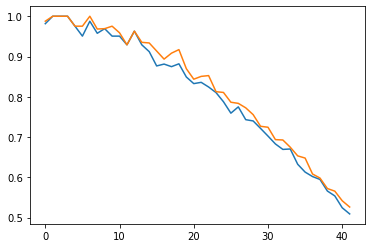

In [44]:
plt.plot(test_accs_i)
plt.plot(test_accs_i_1)

In [75]:
with open("data/natural_distribution.np", 'wb') as f:
    np.save(f, test_losses_i[::-1])

In [76]:
with open("data/natural_distribution.np", 'rb') as f:
    test = np.load(f)

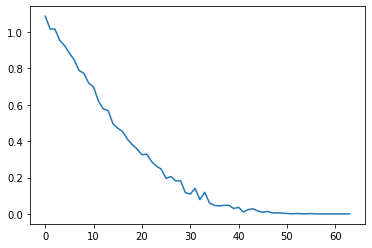

In [77]:
plt.plot(test)

In [ ]:
test_losses_i = []
test_accs_i = []

for i in set(dictionary.keys()):

    x_test_i = x_test[dictionary[i]]
    y_test_i = y_test[dictionary[i]]

    with torch.no_grad():
        y_pred_test_i = model(x_test_i)
        test_loss_i = loss_fn(y_pred_test_i, y_test_i)
        indices = torch.max(y_pred_test_i, 1)[1]
        correct = torch.eq(indices, y_test_i).view(-1)
        test_acc_i = torch.sum(correct)/correct.shape[0]

    test_losses_i.append(test_loss_i.item())
    test_accs_i.append(test_acc_i.cpu())

In [ ]:
def get_index_of_max_value(sudoku_probabilities: np.):
    max_probabilities_cells, cell_values = torch.max(y_pred_test_i, 1)
    return max_probabilities_cells, cell_values



In [45]:
y_pred_test_i.shape

torch.Size([44, 9, 9, 9])

In [59]:
a = y_pred_test_i[0]
print(a.shape)
max_probabilities_cells, cell_values = torch.max(a, 0)
print(max_probabilities_cells.shape)
pos = np.unravel_index(np.argmax(max_probabilities_cells.cpu()), (9,9))
print(max_probabilities_cells)
print(pos)
print(cell_values[pos[0], pos[1]])

torch.Size([9, 9, 9])
torch.Size([9, 9])
tensor([[ 1.6544,  2.0538,  1.6779,  3.3088,  9.0327,  2.4546,  9.6906,  9.6904,
          2.0481],
        [ 2.8702, 13.1760,  2.2502, 21.8826,  2.3492,  1.5851,  0.9853,  0.5976,
          1.2787],
        [ 1.8948,  2.3126, -0.1962,  2.3542,  2.9256,  1.2215,  2.3162,  1.9854,
          1.1307],
        [10.9780, 15.4639,  1.5589,  1.9578,  2.3571,  3.2701, 13.6799,  2.0467,
          1.6675],
        [ 3.2939,  2.3480,  1.4639,  3.5405, 16.9071, 17.8927,  2.0883,  1.6454,
          1.1454],
        [ 3.3591,  2.2474,  0.8756, 16.7747,  1.0996,  1.8344,  0.2157,  1.7479,
          1.8296],
        [12.8563,  2.1971, 14.5450,  1.8511,  1.9930,  2.0258,  1.7412,  3.2542,
         19.9953],
        [ 2.6485,  1.2698,  2.0799,  9.1149,  3.1381,  2.7765,  2.6001, 13.2219,
          2.1020],
        [ 6.1728,  2.9070,  3.1973,  3.5771,  2.1034,  1.5374,  1.7592,  2.9815,
          1.6320]], device='cuda:0')
(1, 3)
tensor(3, device='cuda:0')
tensor(

In [54]:
most_confident_correct_ratio_i = []

for i in set(dictionary.keys()):

    x_test_i = x_test[dictionary[i]]
    y_test_i = y_test[dictionary[i]]
    
    with torch.no_grad():
        y_pred_test_i = model(x_test_i)
        values, indices = torch.max(y_pred_test_i, 1)

        correct = 0

        for i, (value, index) in enumerate(zip(values,indices)):
            pos = np.unravel_index(np.argmax(value.cpu()), (9,9))
            correct += index[pos[0], pos[1]] == y_test_i[i, pos[0], pos[1]]

    most_confident_correct_ratio_i.append((correct/len(values)).cpu()) 

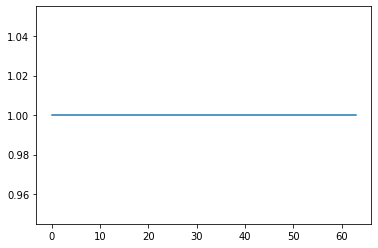

In [55]:
plt.plot(most_confident_correct_ratio_i)

In [42]:
print(np.unravel_index(np.argmax(values[0].cpu(), axis = [1,2]), (9,9)))

TypeError: 'list' object cannot be interpreted as an integer

In [40]:
values.shape

torch.Size([11, 9, 9])